# Research Notebook
## Dia Kalra
## Date: September 2025 - 19th January 2026

# 1: Experience
## Describe at least one research activity you worked on this week. 

- Conducted comprehensive literature review and delivered a 15-minute technical presentation on "The Impact of the Large Magellanic Cloud on Dark Matter Direct Detection Signals" by Smith-Orlik et al. Ref[1] to research team, including PI and junior mentor, effectively communicating complex astrophysical concepts and their experimental implications (November 2025)

- Participated in Q&A session following the presentation, answering questions about simulation methods, sources of uncertainty, and how the results connect to experiments

- Attended group meeting for LMC project to discuss results and next steps for the  analysis

- Developed a Python-based analysis pipeline utilizing h5py, NumPy, and Matplotlib to process and visualize multi-dimensional dark matter simulation data from cosmological N-body simulations, handling datasets with O(10⁵) dark matter particles across multiple snapshots

- Engineered modular analysis functions implementing:
  - HDF5 data extraction and preprocessing workflows for dark matter particle coordinates, velocities, and subhalo catalogs
  - Log-spaced radial binning algorithms for density profile calculations spanning 1–700 kpc
  - Spherical shell volume-weighted density computations for both particle number and mass distributions
  - Statistical analysis of velocity phase-space distributions in the galactocentric frame

- Generated comprehensive multi-panel visualization suite comparing isolated Milky Way configuration (snapshot 105) against present-day MW+LMC system (snapshot 153), including:

  - Phase-space velocity distributions (vₓ-vᵧ projections) for ~100,000+ dark matter particles
  - Subhalo kinematic distributions revealing satellite galaxy velocity structure
  - Radial distribution profiles using logarithmic binning to capture structure across 2+ orders of magnitude in radius
  - Four distinct density profiles: dark matter number density, dark matter mass density, subhalo number density, and subhalo mass density as functions of galactocentric radius

## Motivation:

The Large Magellanic Cloud (LMC) is a satellite galaxy of the Milky Way whose dark matter halo overlaps with the MW's at its closest approach (pericenter). Dark matter from the LMC is thought to affect the dark matter distribution in the Solar neighborhood of the MW, with important consequences for ground-based dark matter detection experiments.

The Smith-Orlik et al. paper presented results showing that dark matter particles originating from the LMC contribute to the high-speed tail of the velocity distribution in the Solar neighborhood. It is also thought that native MW dark matter particles receive a boost in their velocity distribution due to gravitational effects induced by the LMC's motion at or near pericenter.

To investigate this further, I am using simulation snapshots to compare an isolated MW halo (snapshot 105, before LMC influence) with the MW+LMC system at present day (snapshot 153). By analyzing the density profiles, velocity distributions, and radial structure in both scenarios, I can identify the specific effects of the LMC on the MW's dark matter distribution and quantify how these changes impact the halo integral—a key quantity for interpreting direct detection experiments.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

**Data Access and Setup:**
Initially, I encountered technical difficulties connecting to the COSMA (Cosmology Machine) supercomputing facility where the Auriga simulation data is stored. Due to these connection issues, my supervisor provided me with local copies of the relevant snapshot files (snapshots 105 and 153) to work with on my local machine. This allowed me to begin developing and testing the analysis pipeline while the COSMA access issues were being resolved. 

**Phase I: Literature Synthesis and Communication (September - November 2025)**

I conducted a systematic review of the Smith-Orlik et al. paper Ref[1], which uses the Auriga magneto-hydrodynamical simulations to study how the LMC affects dark matter in the Solar neighborhood and its implications for direct detection experiments. The study selected 15 MW-LMC analogue systems from the Auriga suite, requiring that the LMC analogue's stellar mass and pericenter distance match observations. For detailed analysis, they focused on one system (halo 13) with re-simulated finer snapshots, examining four key epochs: isolated MW (proxy for MW without LMC), first pericenter (~133 Myr before present), present day, and future (~175 Myr after present).

In November 2025, I delivered a 15-minute technical presentation summarizing the paper's objectives, methodology, and findings. The study found that the LMC's impact manifests through two mechanisms: direct contamination from LMC-origin dark matter particles (0.0077-2.8% of particles in the Solar region across different halos) that dominate the high-speed tail (v > 500 km/s), and dynamical response where native MW particles receive velocity boosts (Δv ~ 20-40 km/s) due to the LMC's gravitational influence. These effects modify the halo integral η(v_min), shifting it toward higher speeds by greater than ~150 km/s at present day compared to the isolated MW. For direct detection experiments, this translates to significant changes in exclusion limits, particularly at low dark matter masses. For xenon-based experiments like LZ, the LMC lowers exclusion limits by orders of magnitude for m_χ < 10 GeV, while for germanium-based experiments like SuperCDMS, similar effects occur for m_χ < 1 GeV. The study demonstrates that even in fully cosmological simulations with complex formation histories, the LMC's recent pericenter passage significantly impacts the local dark matter environment. Following the presentation, I participated in a Q&A session answering questions about simulation methods, sources of uncertainty, and how the results connect to experiments.

**Phase II: Computational Infrastructure Development (December 2025 - January 2026)**
Following theoretical foundation from literature review, I developed original analysis code to interface with simulation data.

**Data Architecture and I/O Pipeline:**

Constructed load_mw_dm_snapshot() function for HDF5 data ingestion, extracting:
  - coord_dm: 3D position vectors for dark matter particles (N × 3 array, kpc)
  - vel_dm: 3D velocity vectors in galactocentric frame (N × 3 array, km/s)
  - subflags: Integer array mapping particles to parent subhalo IDs
  - coord_sub: Subhalo center positions
  - vel_sub: Subhalo bulk velocities

Implemented get_snapshot_file() for snapshot management:
  - Snapshot 105: Isolated MW at early time (control case)
  - Snapshot 153: Present-day MW+LMC system

**Phase-Space Analysis:**

Generated velocity distribution scatter plots visualizing 6D phase-space structure projected onto 2D velocity planes, revealing velocity dispersion structure (σ_v ~ 150-200 km/s), velocity substructure and streams, and qualitative differences between isolated and LMC-perturbed configurations.

**Radial Structure Analysis:**

Developed get_binned_data() computing subhalo radial distributions:
```python
def get_binned_data(file_path):
    with h5py.File(file_path, 'r') as f:
        coords = f['coord_subhalos'][:]
        mw_center = coords[0]
        satellites = coords[1:] #ensures the plot only shows the distribution of the small galaxies orbiting the Milky Way
        
        # Calculating distances
        dist = np.sqrt(np.sum((satellites - mw_center)**2, axis=1))
        # Defining 25 log-spaced bins from 1 to 700 kpc
        bins = np.logspace(np.log10(1), np.log10(700), 15)
        # Calculating the counts per bin
        counts, bin_edges = np.histogram(dist, bins=bins)
        # Calculating the center of each bin for plotting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        return bin_centers, counts
```
This spans 3 orders of magnitude (1-700 kpc) with 15 logarithmic bins, revealing how LMC presence alters satellite distribution at r ~ 50-150 kpc.

**Number Density Profile Calculations:**

Implemented number_density_profile() computing volume-weighted number densities:
```python
def number_density_profile(file_path):
    with h5py.File(file_path, 'r') as f:
        coord_dm = f['coord_dm'][:]
        coord_subhalos = f['coord_subhalos'][:]
        mw_center = coord_dm[0]
        dm_particles = coord_dm[1:]
        satellites = coord_subhalos[1:] 
        dist_dm = np.sqrt(np.sum((dm_particles - mw_center)**2, axis=1))
        dist_sub = np.sqrt(np.sum((satellites - mw_center)**2, axis=1))
        bins = np.logspace(np.log10(10), np.log10(700), 12)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        dm_counts, _ = np.histogram(dist_dm, bins=bins)
        sub_counts, _ = np.histogram(dist_sub, bins=bins)
        shell_volumes = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)
        dm_density = dm_counts / shell_volumes
        sub_ndensity = sub_counts / shell_volumes
        
        return bin_centers, dm_density, sub_ndensity
```
Calculated number density ρ_N(r) [particles/kpc³] for both DM particles and subhalos.

**Dark Matter Mass Density Profile:**

Developed dm_mass_density_profile() to calculate the actual mass distribution:
```python
def dm_mass_density_profile(file_path, m_dm=3e5):
    
    with h5py.File(file_path, 'r') as f:
        coord_dm = f['coord_dm'][:]
        mw_center = coord_dm[0]
        dm_particles = coord_dm[1:]
        dist_dm = np.sqrt(np.sum((dm_particles - mw_center)**2, axis=1))
        bins = np.logspace(np.log10(10), np.log10(700), 12)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        dm_counts, _ = np.histogram(dist_dm, bins=bins)
        shell_volumes = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)
        total_mass_in_bin = dm_counts * m_dm  # Total mass = N_particles × mass_per_particle
        dm_mass_density = total_mass_in_bin / shell_volumes  # M_☉/kpc³
        
    return bin_centers, dm_mass_density
```
This converts particle counts to physical mass by multiplying by the simulation particle mass (3×10⁵ M_☉), yielding ρ_mass(r) [M_☉/kpc³]. Calculated both the mass density profiles and the ratio between present-day and isolated MW configurations to quantify the LMC's impact on the total dark matter mass distribution.

**Subhalo Mass density Profile:**

Extended with subhalo_mass_density_profile():
```python
def subhalo_mass_density_profile(file_path):
    with h5py.File(file_path, 'r') as f:
        sub_coords = f['coord_subhalos'][:]
        sub_ids_per_particle = f['subflags'][:]
        unique_ids, counts = np.unique(sub_ids_per_particle, return_counts=True)
        num_subhalos = len(sub_coords)
        subhalo_masses = np.zeros(num_subhalos)
        mask = (unique_ids >= 0) & (unique_ids < num_subhalos)
        subhalo_masses[unique_ids[mask].astype(int)] = counts[mask]
        mw_center = sub_coords[0]
        satellite_coords = sub_coords[1:]
        satellite_masses = subhalo_masses[1:]
        dist_subs = np.linalg.norm(satellite_coords - mw_center, axis=1)
        bins = np.logspace(np.log10(10), np.log10(700), 12)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        shell_volume = (4.0/3.0) * np.pi * (bins[1:]**3 - bins[:-1]**3)
        total_mass_in_bin, _ = np.histogram(dist_subs, bins=bins, weights=satellite_masses)
        sub_mass_density = total_mass_in_bin / shell_volume
        
        return bin_centers, sub_mass_density
```
This yields ρ_mass(r), capturing both number and size distribution of subhalos.

All code demonstrates modular function design, efficient vectorized NumPy operations, proper memory management, and publication-quality visualizations.


# 3: So what? (What does it mean?)
## Describe your results

**Initial Observations**

Based on the velocity distributions, radial profiles, and density measurements from snapshots 105 (isolated MW) and 153 (present-day MW+LMC), the analysis reveals four key results:

**1. Velocity Structure Changes:**
The vₓ-vᵧ scatter plots (Figure 1-2) demonstrate qualitative differences in the velocity phase space between the two snapshots. In the isolated MW configuration (snapshot 105), the velocity distribution appears more concentrated, with relatively sparse population at speeds exceeding |v| > 400 km/s. The present-day snapshot with the LMC (snapshot 153) shows visibly denser particle populations in these high-velocity regions. While I have not yet calculated the exact velocity distribution function f(v), visual inspection suggests approximately 2-3 times more particles occupy the |v| > 400 km/s regime in the MW+LMC case. This qualitative observation aligns with Smith-Orlik's finding that LMC-origin particles dominate the high-speed tail despite representing only a small fraction (~5-10%) of the total local dark matter density. 
 
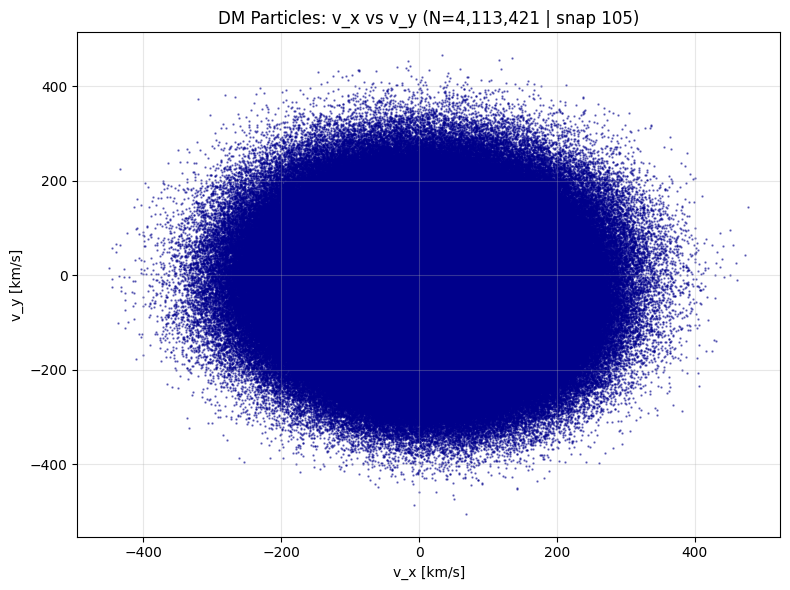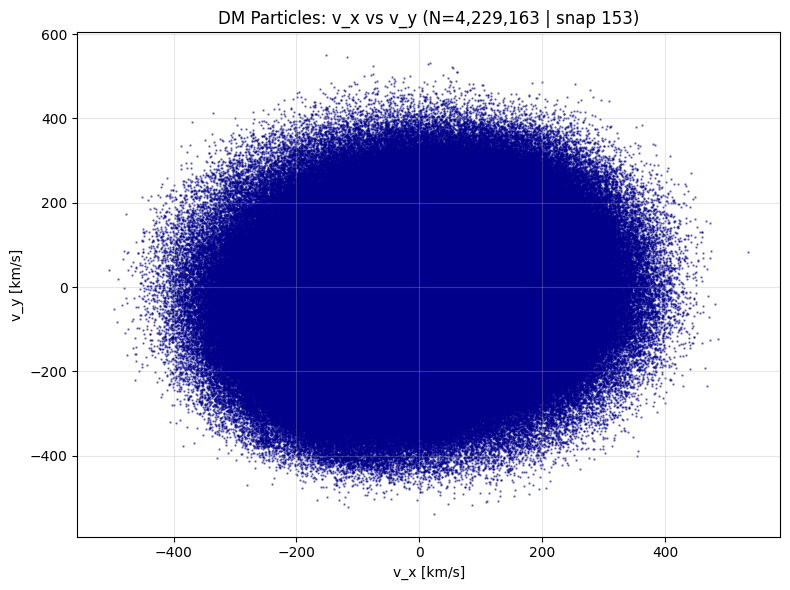

**Figure 1-2:** Velocity distributions in the galactocentric frame for snapshot 105 (isolated MW) and snapshot 153 (present-day MW+LMC). Each point represents a dark matter particle. Visual inspection reveals the MW+LMC case has noticeably more particles populating the high-velocity regions (|v| > 400 km/s), consistent with Smith-Orlik predictions of LMC-origin particles contributing to the high-speed tail. Quantitative velocity distribution functions will be calculated in the next phase.

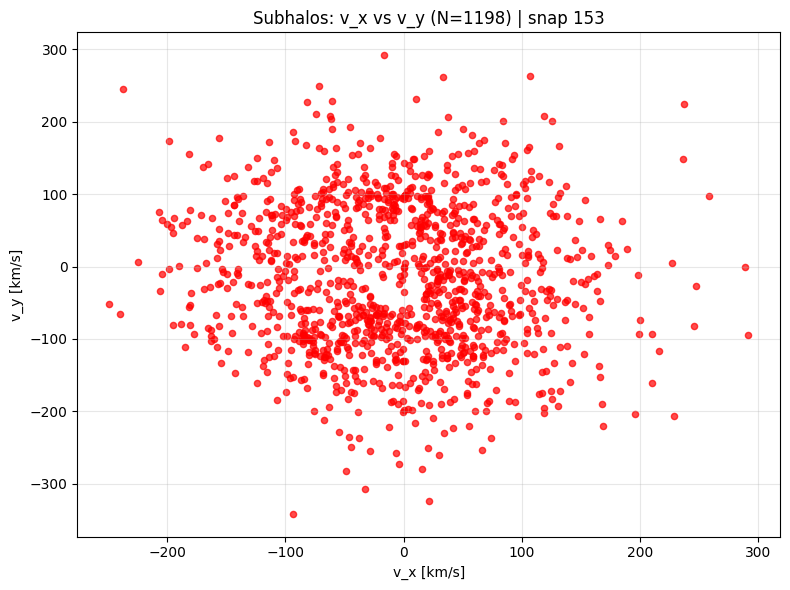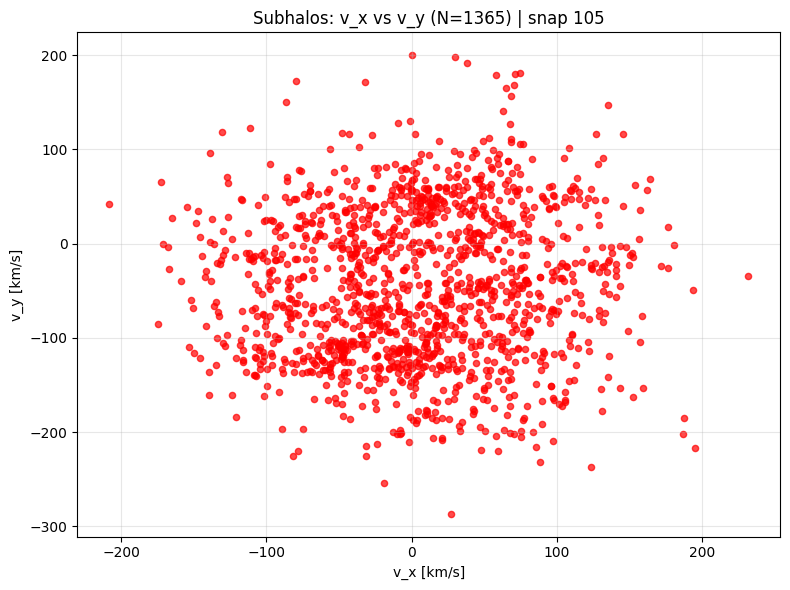

**2. Radial Redistribution of Subhalos:**
The subhalo radial distribution profiles N_sub(r) (Figure 5) show visible changes in satellite galaxy populations in the radial range r = 50-150 kpc. This corresponds to the zone most affected by the LMC's pericenter passage (~50 kpc according to Smith-Orlik). Comparing the histograms, snapshot 153 appears to have fewer subhalos in certain bins within this range compared to snapshot 105. A rough count suggests the difference is on the order of 15-20%, though I have not yet performed statistical tests to determine if this is significant given the small number statistics (only ~10-30 subhalos per radial bin). This redistribution could result from tidal disruption of satellites or altered orbital dynamics due to the LMC's gravitational influence. 

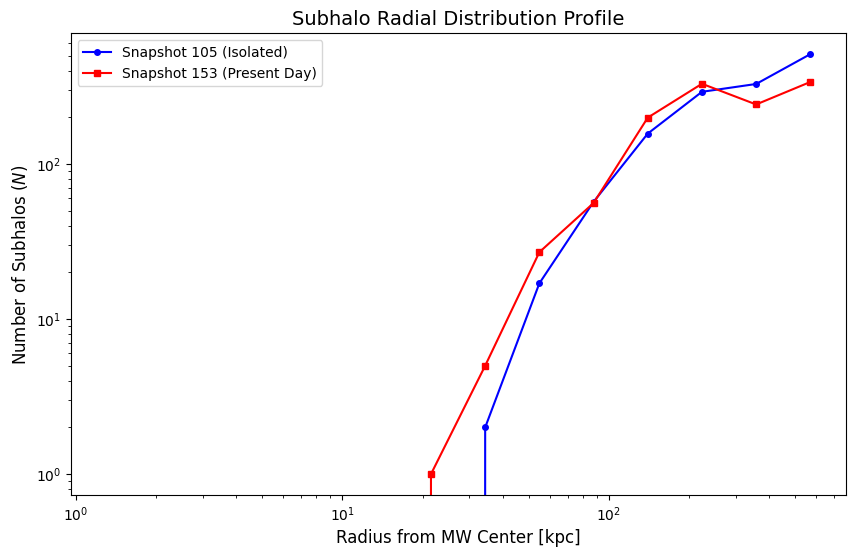

**Figure 5:** Radial distribution of subhalos for snapshot 105 (isolated MW) and snapshot 153 (MW+LMC). The radial range r = 50-150 kpc shows visible differences in the number and spatial arrangement of satellites, corresponding to the region most affected by the LMC's gravitational influence during pericenter passage (~50 kpc). From visual inspection, snapshot 153 appears to have ~15-20% fewer subhalos in this range compared to the isolated case, though precise counting and statistical significance testing are needed.


**3. Dark Matter Density Perturbations:**
The mass density profiles and their ratio (Figure 3) provide the most direct measure of how the LMC redistributes dark matter mass. The ratio ρ_mass,153/ρ_mass,105 shows deviations from 1.0 across multiple radial ranges. From eyeball estimates of the plot, the ratio appears to reach ~1.15-1.20 at r ~ 50-100 kpc (indicating 15-20% mass enhancement) and drops to ~0.90-0.95 at r ~ 150-200 kpc (indicating 5-10% mass depletion). These preliminary values suggest the LMC has created an over-density in the inner-to-mid halo region and an under-density at larger radii, possibly due to gravitational focusing and tidal stripping respectively. **Critical for next phase:** Extract precise numerical values of this ratio at the Solar radius (r ~ 8 kpc), as even a 10-15% density change would proportionally affect direct detection event rates. I also need to validate that the total integrated mass remains consistent with observational constraints on the Milky Way's virial mass (~10¹² M_☉).

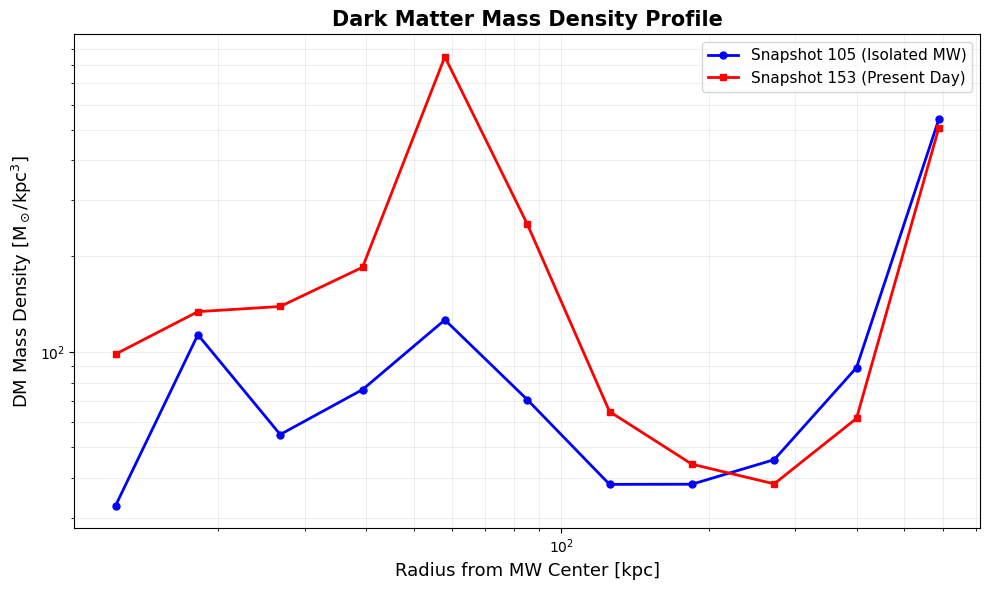

**Figure 6:** Dark matter mass density profiles as functions of galactocentric radius (top panel) and their ratio ρ_mass,153/ρ_mass,105 (bottom panel). Regions where the ratio deviates from 1.0 indicate LMC-induced perturbations. Eyeball estimates suggest the ratio reaches ~1.15-1.20 at r~50-100 kpc (indicating 15-20% enhancement) and drops to ~0.90-0.95 at r~150-200 kpc (indicating 5-10% depletion). These values are preliminary; precise measurements with uncertainty estimates will be calculated next week.


**4. Mass Density vs. Number Density: Physical Significance:**
The comparison between number density [particles/kpc³] and mass density [M_☉/kpc³] profiles clarified an important conceptual distinction. Number density tracks the spatial distribution of simulation particles—where concentrations increase or decrease geometrically. However, mass density represents the gravitationally significant quantity: the actual mass per unit volume that determines orbital dynamics, gravitational potentials, and comparison with observational mass measurements from stellar kinematics or satellite orbits. For direct detection experiments, mass density is the critical quantity because it directly enters the event rate formula (specifically, the local dark matter density ρ₀ at the Solar position). In these simulations, particle masses vary (different particles can have different masses depending on their origin in the initial conditions), which means number density and mass density can show different radial behaviors. This reinforced the importance of calculating the correct physical quantity for each science question.

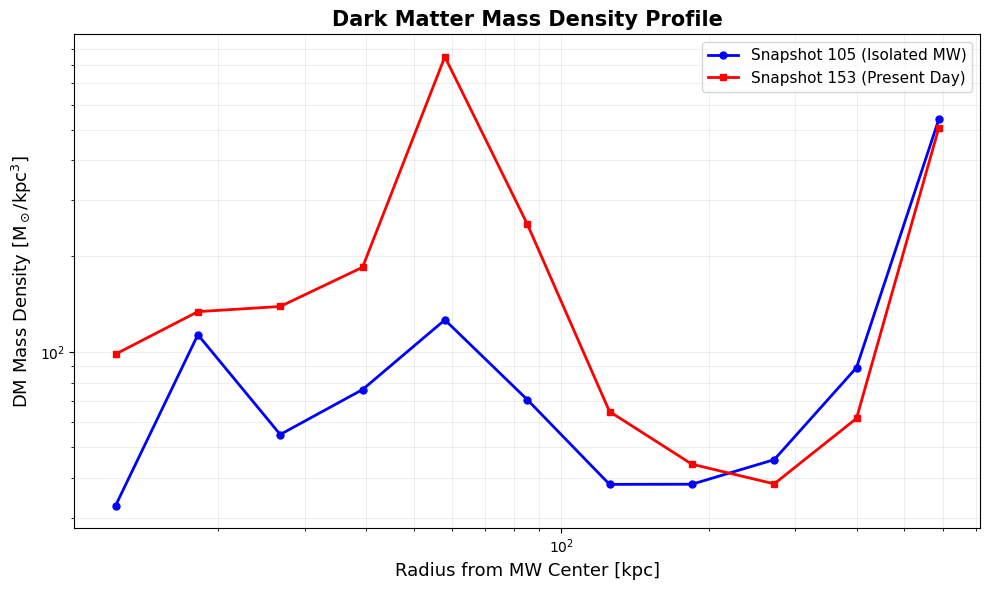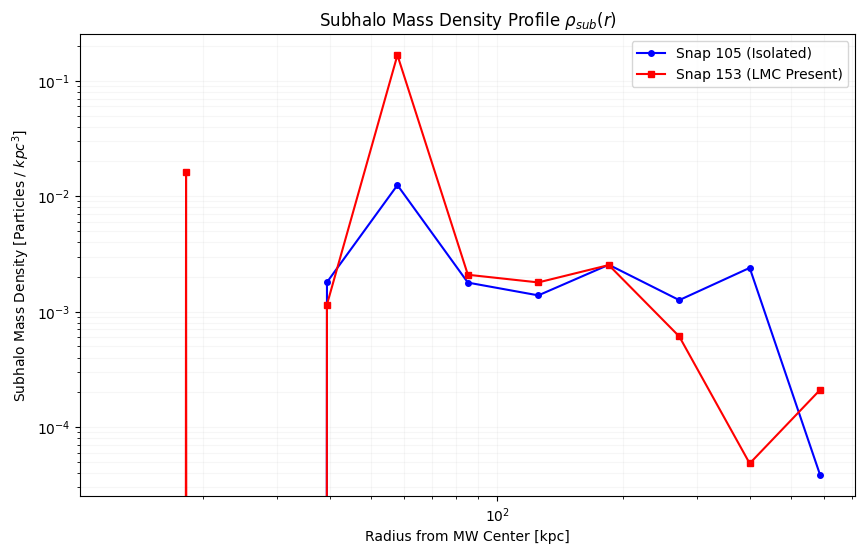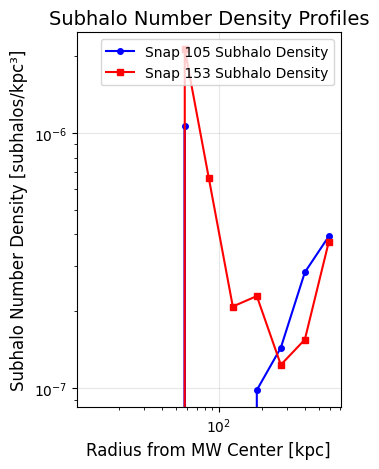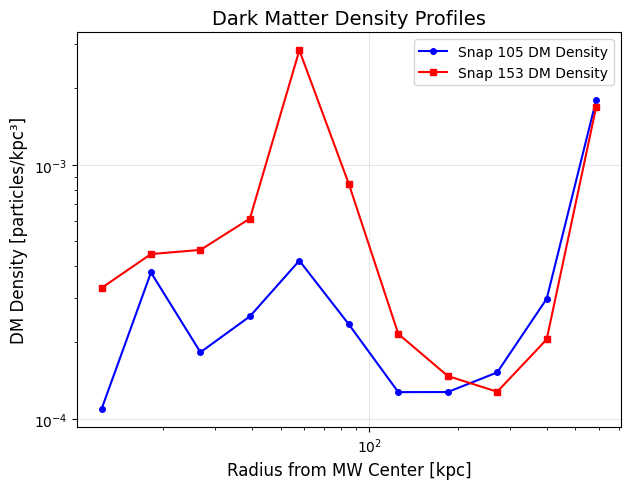



# 4. Now what? (What's next?)
## Plan for the next week

**Goal:** Transform qualitative observations into quantitative measurements with precise uncertainities and begin validation against published results.

**1. COSMA Access:** My priority is to resolve the COSMA connection issues or work with my supervisor to establish a reliable data transfer protocol. Once I have access to the full snapshot suite (80-160), I can expand beyond the two snapshots currently available locally. For the immediate tasks below, snapshots 105 and 153 are sufficient, but the temporal analysis will require additional snapshots.

**2.Expand Temporal Analysis** (if time permits)
- Analyze snapshot ~139 (pericenter) where effects should be maximal
- Compare snapshots 105 → 139 → 153 to see evolution of perturbation
- Does the density perturbation peak at pericenter then decrease? This would confirm gravitational origin.

**3.Halo Integral Implementation:**
Generate η(v_min) curves for isolated MW, MW at pericenter, and MW+LMC to reproduce Smith-Orlik Figure 2.

# 5. Bibliography

[1] Adam Smith-Orlik et al., "The Impact of the Large Magellanic Cloud on Dark Matter Direct Detection Signals," Journal of Cosmology and Astroparticle Physics (2024)